# Introduction to Medical Image Registration using Open Source Toolboxes

### Authors, Acknowledgements etc etc

# Table of Contents
1. [Set-up](#setup)
2. [Introduction to Registration](#IntroReg)
3. [Registration with Deep Learning](#DeepRegistrationIntro)
4. [Third Example](#third-example)
5. [Fourth Example](#fourth-examplehttpwwwfourthexamplecom)
6. [References](#references)

# Set-up <a name="setup"></a>
This tutorial depends on the package DeepReg, which in turn has external dependencies which are managed by `pip`. 

To ensure the demo'd algorithms can run from this Google Colab notebook, you will need to mount your Google Drive and clone the repository into it. You can do this by running the following commands.

You can also follow along in a local copy of the repo - in this case, follow instructions for set up at **Link to local setup instructions**.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
! pwd


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content


In [3]:
import os
# Make a directory in your google drive namde "MICCAI_2020_reg_tutorial"
if not os.path.exists("./MICCAI_2020_reg_tutorial"):
  os.makedirs("./MICCAI_2020_reg_tutorial")
# Move into the dir
%cd ./MICCAI_2020_reg_tutorial
! pwd

/content/MICCAI_2020_reg_tutorial
/content/MICCAI_2020_reg_tutorial


In [4]:
# Clone the DeepReg repository which contains the code
! git clone https://github.com/DeepRegNet/DeepReg.git
%cd ./DeepReg/
# pip install into the notebook env
! pip install -e .
! pwd

Cloning into 'DeepReg'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 4780 (delta 168), reused 165 (delta 76), pack-reused 4505
Receiving objects: 100% (4780/4780), 10.82 MiB | 17.98 MiB/s, done.
Resolving deltas: 100% (3142/3142), done.
/content/MICCAI_2020_reg_tutorial/DeepReg
Obtaining file:///content/MICCAI_2020_reg_tutorial/DeepReg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 92kB 3.8MB/s 
     |████████████████████████████████| 256kB 6.7MB/s 
     |████████████████████████████████| 174kB 7.4MB/s 
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 92kB 5.2MB/s 
     |████████████████████████████████| 102kB 5.0MB/s 
     |████████████████████████████████| 235kB 8.6MB/s 
     |████████████████████████████████| 4.9M

/content/MICCAI_2020_reg_tutorial/DeepReg


# Introduction to Registration <a name="IntroReg"></a>

Image registration is an essential process in many clinical applications and computer assisted interventions **cite**. Applications of medical image registration include - but are not limited to:
* Longitudinal comparison of images for a given patient with the same imaging modality: for example, comparing the outcome of given cancer treatment in a patients' CT scans over time. **cite**
* Inter-subject comparison: for example, **cite**
* Multi-modal registration for image guided surgery: for example, aligning real-time ultrasound scans to pre-operative CT or MRI scans to real-time achieve guidance in neurosurgical or abdominal applications. **cite**

Image registration is the mapping of one coordinate system to another, and can be sub-divided into rigid registrations and non-rigid registrations (depending on whether or not tissue deformations is modelled).

## Classical Registration Methods
* PBR - ICP **example**
* DDF

## Why use Deep Learning for MIR?

# Image Registration with Deep Learning <a name="DeepRegistrationIntro"></a>

For deep learning methods, pairs of images, denoted as moving
and fixed images, are passed to the network to predict a transformation between the images.

The deep learning approach for MIR will depend on mainly three factors:

1. What type of transformation is one trying to predict?
2. What type data is being registered?
3. Is the data paired and/or labeled?

## Types of transformations

- **Predicting a dense displacement field**

  Given a pair of moving and fixed images, a registration network
  can be trained to output dense displacement field (DDF) of the same shape as the moving image. Each value in the DDF
  can be considered as the placement of the corresponding pixel / voxel of the moving
  image. Therefore, the DDF defines a mapping from the moving image's coordinates to the
  fixed image.

  In this tutorial, we mainly focus on DDF-based methods.

- **Predict a dense velocity field**

  Another option is to predict a dense velocity field (DVF) between a pair of images, such that a diffeomorphic
  DDF can be numerically integrated. Read
  ["A fast diffeomorphic image registration algorithm"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.474.1033&rep=rep1&type=pdf)
  for more details.

- **Predict an affine transformation**

  A more constrained option is to predict an affine transformation, parameterised the
  affine transformation matrix of 12 degrees of freedom. The DDF can then be computed to
  resample the moving images in fixed image space.

- **Predict a region of interest**

  Instead of outputting the transformation between coordinates, given moving image,
  fixed image, and a region of interest (ROI) in the moving image, the network can
  predict the ROI in fixed image directly. Interested readers are referred to the MICCAI
  2019 paper:
  [Conditional segmentation in lieu of image registration](https://arxiv.org/abs/1907.00438)


## Data availability - level of supervision

Depending on the availability of the data labels, registration networks can be trained
with different approaches:

### Unsupervised

When the data label is unavailable, training can be achieved via an unsupervised loss.
The
following is an illustration of an unsupervised DDF-based registration network.

![Unsupervised DDF-based registration network](asset/registration-ddf-nn-unsupervised.svg ":size=600")

The loss function often consists of the intensity based loss and deformation loss.

### Weakly-supervised

When there is no intensity based loss that is appropriate for the image pair one would
like to register, the training can take a pair of corresponding moving and fixed labels
(in addition to the image pair), represented by binary masks, to compute a label
dissimilarity (feature based loss) to drive the registration.

Combined with the regularisation on the predicted displacement field, this forms a
weakly-supervised training. An illustration of an weakly-supervised DDF-based
registration network is provided below.

When multiple labels are available for each image, the labels can be sampled during
training iteration, such that only one label per image is used in each iteration of the
data set (epoch). Read [data sampling API](tutorial_sampling.md) for more details.

![Weakly-supervised DDF-based registration network](asset/registration-ddf-nn-weakly-supervised.svg ":size=600")

### Combined

When the data label is available, combining intensity based, feature based, and
deformation based losses together has shown superior registration accuracy, compared to
unsupervised and weakly supervised methods. Following is an illustration of a combined
DDF-based registration network.

![Combined DDF-based registration network](asset/registration-ddf-nn-combined.svg ":size=600")

## Losses - depend on supervision!

To train the deep registration network, measures of similarity between the input images and their transformations are mainly used:

- **Intensity based (image based) loss**

  This type of loss measures the dissimilarity of the fixed image and warped moving
  image, which is adapted from the classical image registration methods. Intensity based
  loss is modality-independent and similar to many other well-studied computer vision
  and medical imaging tasks, such as image segmentation.

  The common loss functions are normalized cross correlation (NCC), sum of squared
  distance (SSD), and normalized mutual information (MI).

- **Feature based (label based) loss**
  Provided labels for the input images, a feature based loss may be used to measure the (dis)similarity of warped regions of interest. Having computed a transformation between images using the net, one of the labels is warped and compared to the ground truth image label.
 Labels are typically manually contoured organs.

  The common loss function is Dice loss, Jacard and average cross-entropy over all
  voxels.

- **Deformation loss**
  Additionally, training may be regularised by computing the "likelihood" of a given displacement field. For DDFs, typical regularisation losses are bending energy losses, L1 or L2 norms of the displacement gradients.

  **Examples**



To demonstrate the power of deep neural networks to perform registration, we provide the following examples:

1. Comparing PBR to a simple net for a rigid deformation
2. Comparing PBR to a simple net for a non-rigid deformation
3. Building a DNN using DeepReg
4. Using a DNN for MIR: adapted demos

# Comparing PBR to a simple net for a rigid deformation 

In [22]:
# Imports
import nibabel
import tensorflow as tf 
import deepreg.model.layer as layer
import deepreg.model.loss.image as image_loss
import deepreg.model.layer_util as layer_util
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np

(30379, 3)


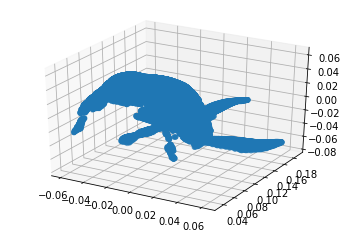

In [21]:
from sksurgerygoicppython import GoICP, POINT3D, ROTNODE, TRANSNODE
def loadPointCloud(array):
    p3dlist = []
    for i in range(len(array.shape[0])):
        pt = POINT3D(array[0, i], array[1, i], array[2, i])
        p3dlist.append(pt)
    return array.shape[0], p3dlist

goicp = GoICP()
Nm, a_points = loadPointCloud(p_cloud)
goicp.loadModelAndData(Nm, a_points)


p_cloud = o3d.io.read_point_cloud("/Users/nina/Downloads/bunny/data/bun090.ply")
p_cloud = np.asarray(p_cloud.points)
print(np.shape(p_cloud))

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(p_cloud[:, 0], p_cloud[:, 1], p_cloud[:, 2])
ax2 = fig.add_subplot(111, projection='3d')


# Generating a random transform
fixed_image_size = moving_image.shape
random_transform = layer_util.random_transform_generator(batch_size=1, scale=0.2)
grid_ref = layer_util.get_reference_grid(grid_size=fixed_image_size[1:4])
fixed_image = layer_util.resample(vol=moving_image, loc=layer_util.warp_grid(grid_ref, random_transform))


In [26]:
! ls
import nibabel
import tensorflow as tf 
import deepreg.model.layer as layer
import deepreg.model.loss.image as image_loss
import deepreg.model.layer_util as layer_util
import matplotlib.pyplot as plt

## registration parameters
image_loss_name = 'ssd'
learning_rate = 0.1
total_iter = int(1000)


## load image
load_image = lambda fn:tf.cast(tf.expand_dims(nibabel.load(fn).dataobj, axis=0), dtype=tf.float32)
moving_image = load_image("./mr_us/unpaired/train/images/case000000.nii.gz")
# moving_image = load_image(os.path.join(os.getcwd(), '/data/mr_us/unpaired/train/images/case000000.nii.gz'))
# fixed_image = load_image('./data/mr_us/unpaired/train/images/case000001.nii.gz')

# random affine-transformed fixed image
fixed_image_size = moving_image.shape
print(fixed_image_size)
random_transform = layer_util.random_transform_generator(batch_size=1, scale=0.2)
grid_ref = layer_util.get_reference_grid(grid_size=fixed_image_size[1:4])
fixed_image = layer_util.resample(vol=moving_image, loc=layer_util.warp_grid(grid_ref, random_transform))


# ## optimisation
# @tf.function
# def train_step(grid, weights, optimizer, mov, fix):
#     """
#     Train step function for backprop using gradient tape    

#     :param grid: reference grid return from layer_util.get_reference_grid
#     :param weights: trainable affine parameters [1, 4, 3]
#     :param optimizer: tf.optimizers
#     :param mov: moving image [1, m_dim1, m_dim2, m_dim3]
#     :param fix: fixed image [1, f_dim1, f_dim2, f_dim3]
#     :return loss: image dissimilarity to minimise
#     """
#     with tf.GradientTape() as tape:
#         pred = layer_util.resample(vol=mov, loc=layer_util.warp_grid(grid, weights))
#         loss = image_loss.similarity_fn(y_true=fix, y_pred=pred, name=image_loss_name)
#     gradients = tape.gradient(loss, [weights])
#     optimizer.apply_gradients(zip(gradients, [weights]))
#     return loss

# # affine transformation as trainable weights
# var_affine = tf.Variable(initial_value=[[[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0],[0.0,0.0,0.0]]], trainable=True)
# optimiser = tf.optimizers.Adam(learning_rate)
# for step in range(total_iter):
#     loss_opt = train_step(grid_ref, var_affine, optimiser, moving_image, fixed_image)
#     if (step % 50) == 0:  # print info
#         tf.print('Step',step, image_loss_name,loss_opt)


# ## predict
# pred_fixed_image = layer_util.resample(vol=moving_image, loc=layer_util.warp_grid(grid_ref, var_affine))

# # display
# idx_slices = [int(5+x*5) for x in range(int(fixed_image_size[3]/5)-1)]
# nIdx = len(idx_slices)
# plt.figure()
# for idx in range(len(idx_slices)):
#     axs = plt.subplot(nIdx, 3, 3*idx+1)
#     axs.imshow(moving_image[0,...,idx_slices[idx]], cmap='gray')
#     axs.axis('off')
#     axs = plt.subplot(nIdx, 3, 3*idx+2)
#     axs.imshow(fixed_image[0,...,idx_slices[idx]], cmap='gray')
#     axs.axis('off')
#     axs = plt.subplot(nIdx, 3, 3*idx+3)
#     axs.imshow(pred_fixed_image[0,...,idx_slices[idx]], cmap='gray')
#     axs.axis('off')
# plt.show()

CODE_OF_CONDUCT.md
CONTRIBUTING.md
ISSUE_TEMPLATE.md
Intro_to_Medical_Image_Regsitration.ipynb
PULL_REQUEST_TEMPLATE.md
_coverpage.md
_navbar.md
_sidebar.md
asset
doc_configuration.md
doc_data_loader.md
index.html
quick_start.md
tutorial_demo.md
tutorial_experiment.md
tutorial_registration.md
tutorial_sampling.md


FileNotFoundError: No such file or no access: '/Users/nina/PhD/Year_1/Research/DeepReg/data/mr_us/unpaired/train/images/case000000.nii.gz'

# Comparing PBR to a simple net for a non-ridid deformation

# Medical Image registration using Deep Learning Demo